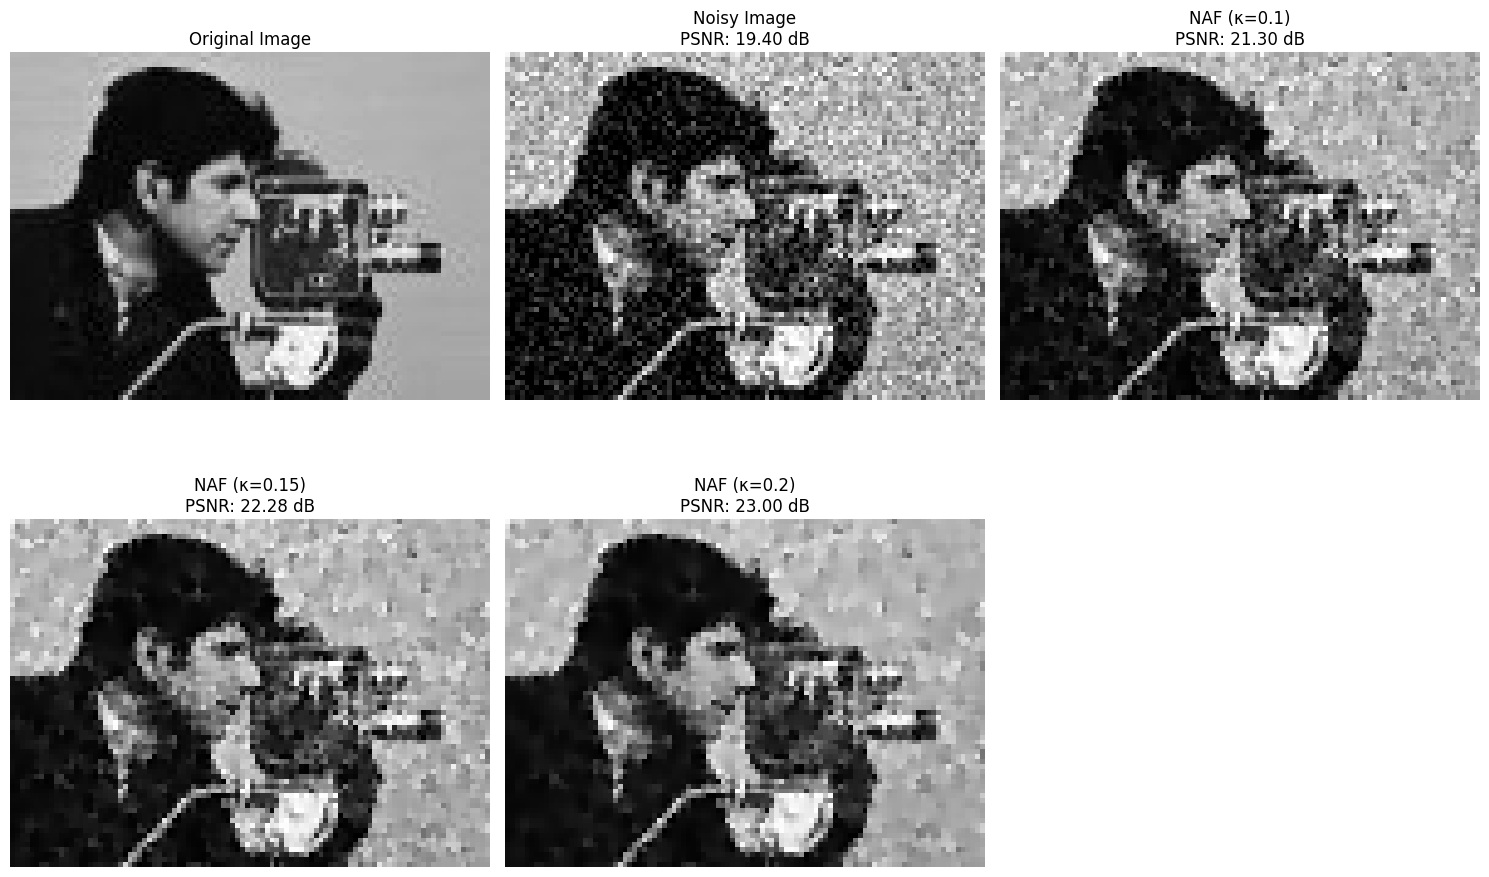

PSNR (Noisy): 19.40 dB
PSNR (κ=0.1): 21.30 dB
PSNR (κ=0.15): 22.28 dB
PSNR (κ=0.2): 23.00 dB


In [1]:
import numpy as np
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from PIL import Image
from skimage import metrics
import warnings
warnings.filterwarnings("ignore")  # Suppress interpolation warnings

# Function to compute gradient magnitude
def compute_gradient_magnitude(image, rho=0):
    if rho > 0:
        image = ndimage.gaussian_filter(image, sigma=rho)
    grad_x = ndimage.sobel(image, axis=1, mode='reflect')
    grad_y = ndimage.sobel(image, axis=0, mode='reflect')
    return np.sqrt(grad_x**2 + grad_y**2)

# Function to perform advection
def advect(image, u, v):
    h, w = image.shape
    x = np.arange(w)
    y = np.arange(h)
    interp = RegularGridInterpolator((y, x), image, method='linear', bounds_error=False, fill_value=0)
    
    # Create meshgrid for coordinates
    X, Y = np.meshgrid(x, y)
    # New coordinates after advection
    new_x = X - u
    new_y = Y - v
    # Clip coordinates to image bounds
    new_x = np.clip(new_x, 0, w-1)
    new_y = np.clip(new_y, 0, h-1)
    # Interpolate
    coords = np.stack((new_y, new_x), axis=-1)
    return interp(coords)

# Nonlinear Advection Filter (NAF)
def NAF(image, n, tau0, kappa, rho):
    result = image.copy()
    for _ in range(n):
        # Random angles for advection field
        theta = np.random.uniform(0, 2*np.pi, image.shape)
        u = np.cos(theta)
        v = np.sin(theta)
        # Compute gradient magnitude
        grad_mag = compute_gradient_magnitude(result, rho)
        # Compute tau based on gradient
        tau = tau0 * (1 / (1 + (grad_mag / kappa)**2))
        # Scale advection field
        u_scaled = tau * u
        v_scaled = tau * v
        # Advect image
        result = advect(result, u_scaled, v_scaled)
    return result

# Load image
image_path = r"Input Image/naf_original_cameraman.jpg"
try:
    image = np.array(Image.open(image_path).convert('L')).astype(np.float32) / 255.0  # Convert to grayscale and normalize
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    exit(1)

# Add Gaussian noise (sigma = 30/255 after normalization)
sigma = 30 / 255.0
noisy_image = image + np.random.normal(0, sigma, image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

# Parameters
n = 100
tau0 = 0.05
rho = 0
kappa_values = [0.10, 0.15, 0.20]

# Apply NAF for each kappa
filtered_images = {}
for kappa in kappa_values:
    filtered_images[kappa] = NAF(noisy_image, n, tau0, kappa, rho)

# Calculate PSNR
psnr_noisy = metrics.peak_signal_noise_ratio(image, noisy_image, data_range=1.0)
psnr_filtered = {kappa: metrics.peak_signal_noise_ratio(image, filtered_images[kappa], data_range=1.0)
                 for kappa in kappa_values}

# Display results
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Noisy image
plt.subplot(2, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image\nPSNR: {psnr_noisy:.2f} dB')
plt.axis('off')

# Filtered images
for i, kappa in enumerate(kappa_values, 3):
    plt.subplot(2, 3, i)
    plt.imshow(filtered_images[kappa], cmap='gray')
    plt.title(f'NAF (κ={kappa})\nPSNR: {psnr_filtered[kappa]:.2f} dB')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print PSNR values
print(f"PSNR (Noisy): {psnr_noisy:.2f} dB")
for kappa in kappa_values:
    print(f"PSNR (κ={kappa}): {psnr_filtered[kappa]:.2f} dB")